/tmp/ipython-input-1676227414.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Running Advanced Model (LSTM) ---
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.1280
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0105
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0050
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0045
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0037
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

--- Running GenAI Sentiment Analysis ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


GenAI Analysis of Recent Headlines:
 - 'Inflation rises again, causing market panic' -> negative (Confidence: 0.91)
 - 'Nvidia announces revolutionary AI chip, stock expected to soar' -> positive (Confidence: 0.62)
 - 'Federal Reserve pauses interest rate hikes' -> neutral (Confidence: 0.55)
 - 'Company reports massive loss due to supply chain failure' -> negative (Confidence: 0.97)


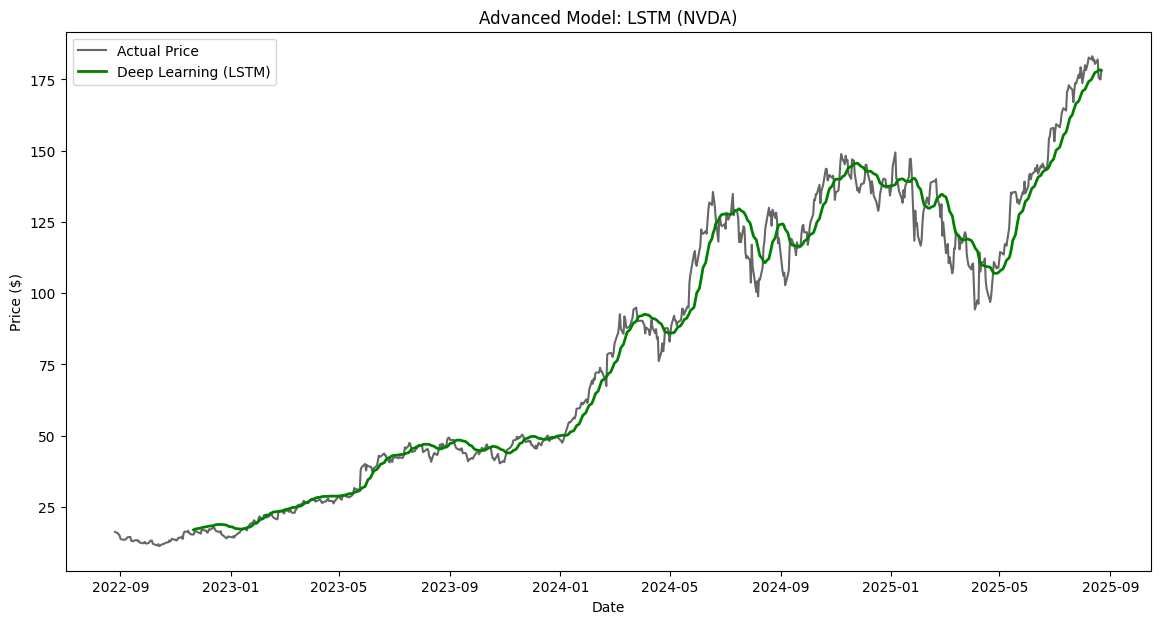

In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from transformers import pipeline

def fetch_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)

    if len(df) == 0:
        raise ValueError("No data found. Check your internet connection or ticker symbol.")

    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    if isinstance(df.columns, pd.MultiIndex):
        df = df['Close']
    else:
        df = df[['Close']]

    df = df.dropna()
    return df

def run_lstm_model(df):
    """
    Trains a Long Short-Term Memory (LSTM) network.
    """
    print("\n--- Running Advanced Model (LSTM) ---")

    data = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    prediction_days = 60
    x_train, y_train = [], []

    for i in range(prediction_days, len(scaled_data)):
        x_train.append(scaled_data[i-prediction_days:i, 0])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)

    predictions = model.predict(x_train)
    predictions = scaler.inverse_transform(predictions)

    pad_col = np.empty((prediction_days, 1))
    pad_col[:] = np.nan
    final_predictions = np.vstack((pad_col, predictions))

    df['LSTM_Prediction'] = final_predictions
    return df

def run_genai_sentiment():
    print("\n--- Running GenAI Sentiment Analysis ---")

    headlines = [
        "Inflation rises again, causing market panic",
        "Nvidia announces revolutionary AI chip, stock expected to soar",
        "Federal Reserve pauses interest rate hikes",
        "Company reports massive loss due to supply chain failure"
    ]

    try:
        pipe = pipeline("sentiment-analysis", model="ProsusAI/finbert")
        results = pipe(headlines)

        print("GenAI Analysis of Recent Headlines:")
        for headline, result in zip(headlines, results):
            print(f" - '{headline}' -> {result['label']} (Confidence: {result['score']:.2f})")
    except Exception as e:
        print(f"Could not load FinBERT model (likely internet issue): {e}")

if __name__ == "__main__":
    end = dt.datetime(2025, 8, 25)
    start = end - dt.timedelta(days=3*365)
    TICKER = "NVDA"

    stock_df = fetch_data(TICKER, start, end)

    if TICKER in stock_df.columns and len(stock_df.columns) == 1:
        stock_df.rename(columns={TICKER: 'Close'}, inplace=True)

    stock_df = run_lstm_model(stock_df)

    run_genai_sentiment()

    plt.figure(figsize=(14, 7))
    plt.plot(stock_df.index, stock_df['Close'], label='Actual Price', color='black', alpha=0.6)
    plt.plot(stock_df.index, stock_df['LSTM_Prediction'], label='Deep Learning (LSTM)', color='green', linewidth=2)

    plt.title(f'Advanced Model: LSTM ({TICKER})')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()